In [1]:
from src import simulations, preprocess, data, trainer, models
import pandas as pd
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

import torch.nn as nn
import torch 

font = {'size'   : 14}

matplotlib.rc('font', **font)

/opt/homebrew/Caskroom/miniconda/base/envs/cpr/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniconda/base/envs/cpr/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniconda/base/envs/cpr/l

## Probabilistic Agent A

In [2]:
N = 2000
seq_length = 9
X = [simulations.sequence(n=seq_length, p=0, lower_bound=-1, upper_bound=1) for i in range(N)]
AT = [simulations.agent_p_a(x) for x in X]
I = [[i] * seq_length for i in range(N)]

df = pd.DataFrame({"x": [item for sublist in X for item in sublist], 
                   "a": [item for sublist in [item[0] for item in AT] for item in sublist],
                   "theta": [item for sublist in [item[1] for item in AT] for item in sublist],
                   "i": [item for sublist in I for item in sublist]})

loader_train, loader_val, loader_test = simulations.create_simulation_loader(df, seq_length=seq_length, add_intercept=False)

hidden_dims = [16, 32, 64]
lambdas = [0]

context_size = 3
input_size = 1

exp_name = "Simulation_prob_a"

trainer.train_contextual(exp_name=exp_name, input_size=input_size, context_size=context_size, train_loader=loader_train, 
                         val_loader=loader_val, hidden_dims=hidden_dims, lambdas=lambdas, lr=5e-4)

best_context_l = trainer.get_best_run(exp=exp_name, pref="context_LSTM")
best_context_l_model = trainer.load_run(run=best_context_l, dataset_name=exp_name)
pred_context, true_context = models.model_predict(best_context_l_model, loader_test)
trainer.calculate_results(pred = pred_context, true=true_context)

Run context_LSTM_16_0 already exists, skipping.
Run context_LSTM_32_0 already exists, skipping.
Run context_LSTM_64_0 already exists, skipping.


(0.7636949546116973,
 0.7672030031489137,
 0.19648831572768485,
 0.6866666666666668)

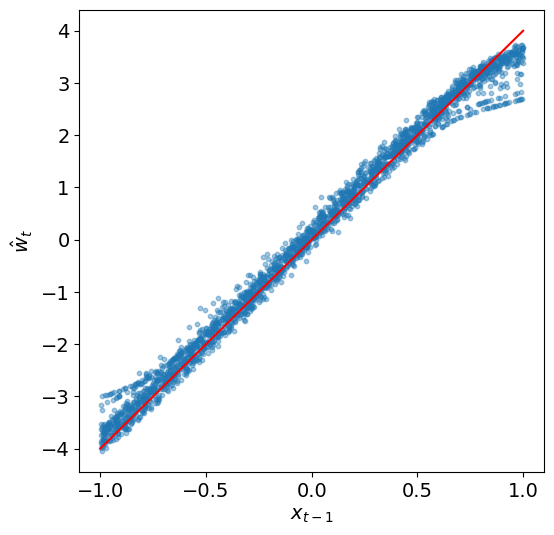

In [3]:
coef_df, enc = models.map_to_2d(model = best_context_l_model, loader_test=loader_test, feature_cols=["x"], 
                                include_intercept=False)

coef_df.x = coef_df.x.astype(float)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(loader_test.dataset.df.theta, coef_df.x, s=10, alpha=0.4)
ax.plot([-1,1],[-4,4], c="red")
plt.xlabel("$x_{t-1}$")
plt.ylabel(r"$\hat{w}_t$")
#plt.title(f"Predicted vs. true theta - corr: {round(k.theta.corr(k.theta_hat), 2)}")
fig.savefig("../figures/Simulation_prob_a.pdf", bbox_inches="tight")

In [4]:
np.corrcoef(coef_df.x, loader_test.dataset.df.theta)[0,1]

0.9951135273046046

## Probabilistic Agent B

In [12]:
N = 2000
seq_length = 9
X = [simulations.sequence(n=seq_length, p=0, lower_bound=-1, upper_bound=1) for i in range(N)]
AT = [simulations.agent_p_b(x) for x in X]
I = [[i] * seq_length for i in range(N)]
T = [[i+1 for i in range(seq_length)] for i in range(N)]

df = pd.DataFrame({"x": [item for sublist in X for item in sublist], 
                   "a": [item for sublist in [item[0] for item in AT] for item in sublist],
                   "theta": [item for sublist in [item[1] for item in AT] for item in sublist],
                   "intercept": [item for sublist in [item[2] for item in AT] for item in sublist],
                   "i": [item for sublist in I for item in sublist],
                   "t": [item for sublist in T for item in sublist]})

loader_train, loader_val, loader_test = simulations.create_simulation_loader(df, seq_length=seq_length, add_intercept=True)

In [13]:
hidden_dims = [16, 32, 64]
lambdas = [0]

context_size = 3
input_size = 2

exp_name = "Simulation_prob_b"

trainer.train_contextual(exp_name=exp_name, input_size=input_size, context_size=context_size, train_loader=loader_train, 
                         val_loader=loader_val, hidden_dims=hidden_dims, lambdas=lambdas, lr=5e-4)

best_context_l = trainer.get_best_run(exp=exp_name, pref="context_LSTM")
best_context_l_model = trainer.load_run(run=best_context_l, dataset_name=exp_name)
pred_context, true_context = models.model_predict(best_context_l_model, loader_test)
trainer.calculate_results(pred = pred_context, true=true_context)

Run context_LSTM_16_0 already exists, skipping.
Run context_LSTM_32_0 already exists, skipping.
Run context_LSTM_64_0 already exists, skipping.


(0.8178937965304116,
 0.8179910201080394,
 0.17437626855341565,
 0.7429201912467819)

In [14]:
coef_df, enc = models.map_to_2d(model = best_context_l_model, loader_test=loader_test, feature_cols=["x"])

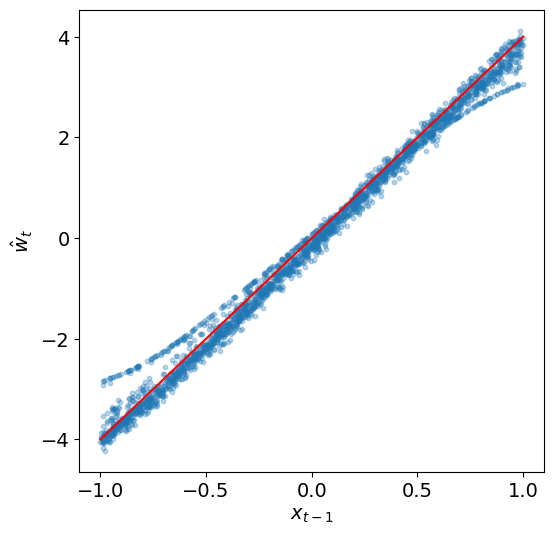

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(loader_test.dataset.df.theta, coef_df.x, s=10, alpha=0.3)
ax.plot([-1,1],[-4,4], c="red")
plt.xlabel("$x_{t-1}$")
plt.ylabel(r"$\hat{w}_t$")
#plt.title(f"Predicted vs. true theta - corr: {round(k.theta.corr(k.theta_hat), 2)}")
fig.savefig("../figures/Simulation_prob_b_w.pdf", bbox_inches="tight")

In [17]:
np.corrcoef(loader_test.dataset.df.theta, coef_df.x)[0,1]

0.9957248645057948

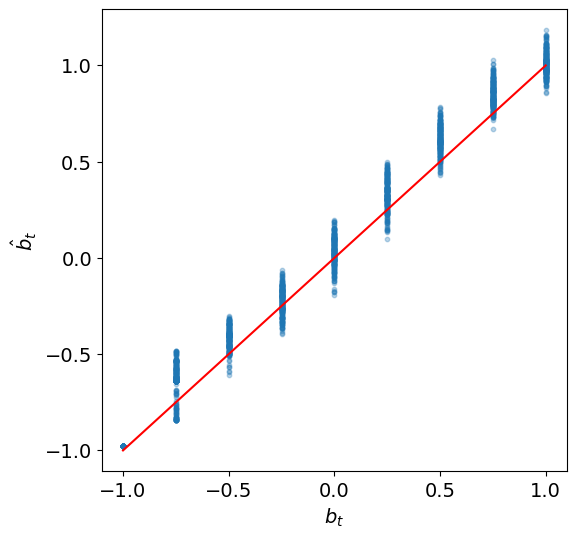

In [16]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(loader_test.dataset.df.intercept, coef_df.intercept, s=10, alpha=0.3)
ax.plot([-1,1],[-1,1], c="red")
plt.xlabel("$b_t$")
plt.ylabel(r"$\hat{b}_t$")
#plt.title(f"Predicted vs. true theta - corr: {round(k.theta.corr(k.theta_hat), 2)}")
fig.savefig("../figures/Simulation_prob_b_b.pdf", bbox_inches="tight")

In [19]:
np.corrcoef(loader_test.dataset.df.intercept, coef_df.intercept)[0,1]

0.9928410653969306

# Deterministic Agent 

In [34]:
N = 2000
seq_length = 9
X = [simulations.sequence(n=seq_length, p=0, lower_bound=0, upper_bound=1) for i in range(N)]
AC = [simulations.agent_d(x1) for x1 in X] 
I = [[i] * seq_length for i in range(N)]
t = [list(range(seq_length)) for j in range(N)]
A = [a for a,c in AC]
c = [c for a,c in AC]

feature_cols = ["x"]

df = pd.DataFrame({"x": [item for sublist in X for item in sublist], "a": [item for sublist in A for item in sublist], 
                   "i": [item for sublist in I for item in sublist], "t": [item for sublist in t for item in sublist], 
                   "c": [item for sublist in c for item in sublist]})

loader_train, loader_val, loader_test = simulations.create_simulation_loader(df, seq_length=seq_length)

hidden_dims = [16,32,64]
lambdas = [0]

input_size = 2
context_size = 3

exp_name = "Simulation_d"

trainer.train_contextual(exp_name=exp_name, input_size=input_size, context_size=context_size, train_loader=loader_train, 
                         val_loader=loader_val, hidden_dims=hidden_dims, lambdas=lambdas, lr=5e-2)

best_context_l = trainer.get_best_run(exp=exp_name, pref="context_LSTM")
best_context_l_model = trainer.load_run(run=best_context_l, dataset_name=exp_name)
pred_context, true_context = models.model_predict(best_context_l_model, loader_test)
trainer.calculate_results(pred = pred_context, true=true_context)


Run context_LSTM_16_0 already exists, skipping.
Run context_LSTM_32_0 already exists, skipping.
Run context_LSTM_64_0 already exists, skipping.


(0.9999749958187453,
 0.9999696279688028,
 0.003590212794412383,
 0.9987494789495623)

In [35]:
coef_df, enc = models.map_to_2d(model = best_context_l_model, loader_test=loader_test, feature_cols=feature_cols)

steps = 101
hm = np.vstack((np.linspace(0,1, steps), np.ones(steps))).T

coef_df_c = pd.merge(coef_df, loader_test.dataset.df[['i', 'c', 't']], left_on=["id", "t"], right_on=["i", "t"])

coef_df_0 = coef_df_c[coef_df_c["c"]==0]
coef_df_1 = coef_df_c[coef_df_c["c"]==1]

sig = nn.Sigmoid()
logits = coef_df_0[["x", "intercept"]].values @ hm.T 
probs_0 = sig(torch.tensor(logits)).numpy()

p0_mean = np.mean(probs_0, axis=0)
p0_std = np.std(probs_0, axis=0)

logits = coef_df_1[["x", "intercept"]].values @ hm.T 
probs_1 = sig(torch.tensor(logits)).numpy()

p1_mean = np.mean(probs_1, axis=0)
p1_std = np.std(probs_1, axis=0)

fig, ax = plt.subplots()

ax.plot(hm[:,0], p0_mean, label=r"$x_{t-1}\leq0.5$")
ax.plot(hm[:,0], p1_mean, label=r"$x_{t-1} > 0.5$")
ax.fill_between(hm[:,0], p0_mean-p0_std, p0_mean+p0_std, alpha=0.2)
ax.fill_between(hm[:,0], p1_mean-p1_std, p1_mean+p1_std, alpha=0.2)

ax.legend()
#ax.hlines(0.5, 0, 1, linestyles="dashed")

ax.set_xlabel("$x_t$")
ax.set_ylabel("$P(a_t|x_t,x_{t-1})$")
ax.vlines(0.5, 0, 1, linestyles="dashed", colors="grey")

fig.savefig("../figures/Simulation_det.pdf", bbox_inches="tight")

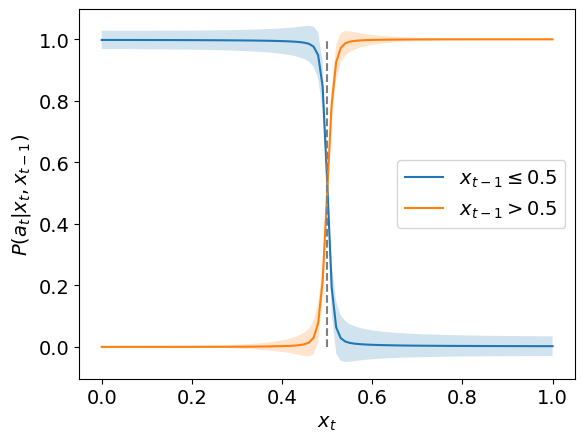